### Importing required modules

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import TensorDataset,random_split,DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import pickle

### Loading data

In [2]:
file_path = 'C:\Data\Study\Ai_adventures\Projects\Deep _Learning\Android-Malware Detection\outputs\processed_data.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

In [3]:
X = data["features"]
y = data["targets"]

- Creating Tesnor dataset

In [4]:
def Dataset(X,y):
    features = X.to_numpy()
    labels = y.to_numpy()

    features_tensor = torch.tensor(features)
    labels_numeric = np.where(labels=="MALWARE",1,0).reshape(-1,1)
    labels_tensor = torch.tensor(labels_numeric,dtype=torch.float32)

    data = TensorDataset(features_tensor,labels_tensor)
    return data

In [5]:
data = Dataset(X,y)
data

In [6]:
len(data)

610492

- Splitting data

In [7]:
train_ds, val_ds, test_ds = random_split(data,[len(data)-15000,10000,5000])

- Data Loaders

In [34]:
batch_size = 10000
train_dl = DataLoader(train_ds,batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds,batch_size)

In [35]:
for xb,yb in train_dl:
    print(xb,yb)
    break

tensor([[4.4300e+02, 1.1776e+08, 6.0000e+00,  ..., 2.9684e+04, 5.8600e+07,
         5.8500e+07],
        [8.0000e+01, 6.3128e+07, 2.0000e+00,  ..., 0.0000e+00, 6.3100e+07,
         6.3100e+07],
        [8.0000e+01, 3.6995e+04, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.3000e+01, 6.0978e+04, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3000e+01, 2.3561e+04, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3000e+01, 4.6064e+05, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64) tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


In [36]:
for batch in train_dl:
    features,labels = batch
    print(features.shape,labels)
    break

torch.Size([10000, 78]) tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]])


- Model building 

In [37]:
def accuracy(outputs,actuals):
    _,preds = torch.max(outputs,dim=1)
    acc = torch.tensor(torch.sum(preds==actuals).item()/len(preds))
    return acc

class LogisticRegression(nn.Module):
    def training_step(self,batch):
        features,labels = batch
        outputs = self(features)
        loss = F.cross_entropy(outputs,labels.squeeze().long())
        return loss
    def validation_step(self,batch):
        features,labels = batch
        outputs = self(features)
        loss = F.cross_entropy(outputs,labels.squeeze().long())
        acc = accuracy(outputs,labels.squeeze().long())
        return {"val loss":loss.detach(),"val acc":acc}
    def validation_epoch_end(self,outputs):
        batch_loss = [x["val loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val loss":epoch_loss.item(),"val acc":epoch_acc.item()}
    def epoch_end(self, epoch_num, results, fit_one_cycle=False):
        if fit_one_cycle:
            print("Epoch [{}], last_lr: {:.5f}, train loss: {:.4f}, val loss: {:.4f}, val acc: {:.4f}".format(
                epoch_num, results['lrs'][-1], results['train loss'], results['val loss'], results['val acc']))
        else:
            print("Epoch[{}] -> TRAIN LOSS : {:.4f} | VALIDATION LOSS : {:.4f} | VALIDATION ACC : {:.4f}".format(
                epoch_num, results["train loss"], results["val loss"], results["val acc"]))
    @torch.no_grad()
    def evaluate(self,val_dl):
        self.eval()
        outputs = [self.validation_step(batch) for batch in val_dl]
        return self.validation_epoch_end(outputs)

In [38]:
def linear_block(in_channels, out_channels):
    layers = [
        nn.Linear(in_channels, out_channels),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(inplace=True)
    ]
    return nn.Sequential(*layers)

class NetworkArchitecture(LogisticRegression):
    def __init__(self):
        super().__init__()
        self.linear1 = linear_block(len(train_ds[0][0]), 50)
        self.linear2 = linear_block(50, 25)
        self.linear3 = linear_block(25, 10)
        self.classifier = nn.Linear(10, 2)
    
    def forward(self, xb):
        out = self.linear1(xb.float())
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.classifier(out)
        return out   

In [39]:
model_f = NetworkArchitecture()
model_foc = NetworkArchitecture()
model_f

NetworkArchitecture(
  (linear1): Sequential(
    (0): Linear(in_features=78, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (linear2): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (linear3): Sequential(
    (0): Linear(in_features=25, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=10, out_features=2, bias=True)
)

- Training using fit

In [40]:
def fit(epoch_num,lr,model,train_dl,val_dl,optim_func):
    optimizer = optim_func(model.parameters(),lr)
    history = []
    for epoch in range(epoch_num):
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        results = model.evaluate(val_dl)
        results["train loss"] = torch.stack(train_losses).mean()
        model.epoch_end(epoch,results)
        history.append(results)
    return history

In [41]:
model_f.evaluate(val_dl)

{'val loss': 694025.1875, 'val acc': 0.32100000977516174}

In [42]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [43]:
history = fit(num_epochs, lr, model_f, train_dl, val_dl, opt_func)

Epoch[0] -> TRAIN LOSS : 57888.6094 | VALIDATION LOSS : 2572.4312 | VALIDATION ACC : 0.8786
Epoch[1] -> TRAIN LOSS : 3879.0896 | VALIDATION LOSS : 3626.9849 | VALIDATION ACC : 0.8977
Epoch[2] -> TRAIN LOSS : 3865.6062 | VALIDATION LOSS : 4876.8638 | VALIDATION ACC : 0.8010
Epoch[3] -> TRAIN LOSS : 2983.6912 | VALIDATION LOSS : 3902.2024 | VALIDATION ACC : 0.9058
Epoch[4] -> TRAIN LOSS : 2475.3633 | VALIDATION LOSS : 1191.9596 | VALIDATION ACC : 0.9358
Epoch[5] -> TRAIN LOSS : 2618.4976 | VALIDATION LOSS : 1354.7546 | VALIDATION ACC : 0.9448
Epoch[6] -> TRAIN LOSS : 1959.2599 | VALIDATION LOSS : 2440.4041 | VALIDATION ACC : 0.9378
Epoch[7] -> TRAIN LOSS : 2168.3083 | VALIDATION LOSS : 1882.2913 | VALIDATION ACC : 0.9325
Epoch[8] -> TRAIN LOSS : 2034.8658 | VALIDATION LOSS : 1476.7072 | VALIDATION ACC : 0.9453
Epoch[9] -> TRAIN LOSS : 956.1481 | VALIDATION LOSS : 2680.8657 | VALIDATION ACC : 0.9512
Epoch[10] -> TRAIN LOSS : 3768.1265 | VALIDATION LOSS : 5127.7163 | VALIDATION ACC : 0.921

In [44]:
def plot_accuracies(history):
    accuracies = [x['val acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

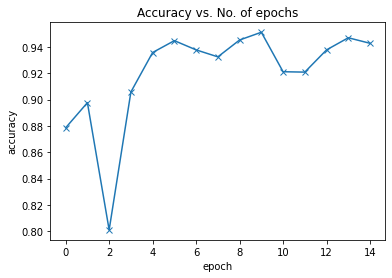

In [45]:
plot_accuracies(history)

In [46]:
def plot_losses(history):
    train_losses = [x.get('train loss').detach().numpy() for x in history]
    val_losses = [x['val loss'].detach().numpy() if isinstance(x['val loss'], torch.Tensor) else x['val loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

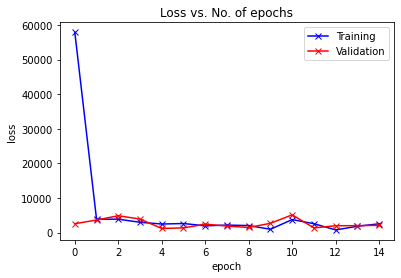

In [47]:
plot_losses(history)

- Training using fit one cycle

In [48]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        result = model.evaluate(val_loader)
        result['train loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
history_foc = [model_foc.evaluate(val_dl)]
history_foc

[{'val loss': 13508.802734375, 'val acc': 0.6309999823570251}]

In [50]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [51]:
%%time
history_foc += fit_one_cycle(epochs, max_lr, model_foc,
                         train_dl, val_dl, 
                         grad_clip = grad_clip, 
                         weight_decay = weight_decay, 
                         opt_func = opt_func)

Epoch[0] -> TRAIN LOSS : 0.4219 | VALIDATION LOSS : 0.3228 | VALIDATION ACC : 0.9235
Epoch[1] -> TRAIN LOSS : 0.2332 | VALIDATION LOSS : 0.1750 | VALIDATION ACC : 0.9550
Epoch[2] -> TRAIN LOSS : 0.1603 | VALIDATION LOSS : 0.3166 | VALIDATION ACC : 0.9324
Epoch[3] -> TRAIN LOSS : 0.1596 | VALIDATION LOSS : 0.2080 | VALIDATION ACC : 0.9486
Epoch[4] -> TRAIN LOSS : 0.1478 | VALIDATION LOSS : 0.1636 | VALIDATION ACC : 0.9522
Epoch[5] -> TRAIN LOSS : 0.1443 | VALIDATION LOSS : 0.1474 | VALIDATION ACC : 0.9560
Epoch[6] -> TRAIN LOSS : 0.1421 | VALIDATION LOSS : 0.1589 | VALIDATION ACC : 0.9543
Epoch[7] -> TRAIN LOSS : 0.1362 | VALIDATION LOSS : 0.1278 | VALIDATION ACC : 0.9632
Epoch[8] -> TRAIN LOSS : 0.1304 | VALIDATION LOSS : 0.1402 | VALIDATION ACC : 0.9625
Epoch[9] -> TRAIN LOSS : 0.1278 | VALIDATION LOSS : 0.1442 | VALIDATION ACC : 0.9572
Epoch[10] -> TRAIN LOSS : 0.1229 | VALIDATION LOSS : 0.1210 | VALIDATION ACC : 0.9631
Epoch[11] -> TRAIN LOSS : 0.1181 | VALIDATION LOSS : 0.1187 | VA

In [52]:
def plot_accuracies(history):
    accuracies = [x['val acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

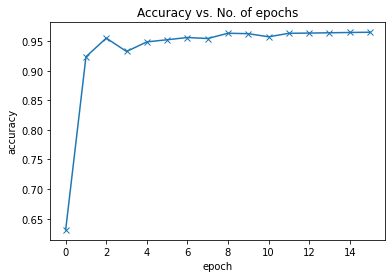

In [53]:
plot_accuracies(history_foc)

In [54]:
def plot_losses(history):
    train_losses = [x.get('train loss') for x in history]
    val_losses = [x['val loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

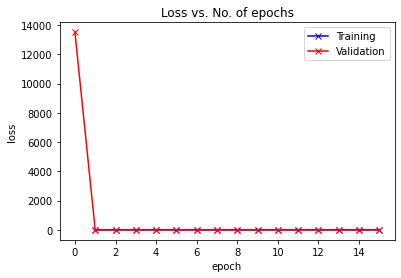

In [55]:
plot_losses(history_foc)

In [56]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

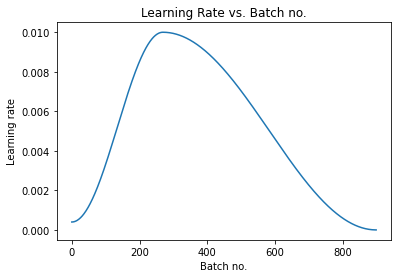

In [57]:
plot_lrs(history_foc)

- Saving the w&b

In [58]:
folder_path = 'C:/Data/Study/Ai_adventures/Projects/Deep _Learning/Android-Malware Detection/models/'
torch.save(model_foc.state_dict(), folder_path + 'model_weights.pth')

- Reloading the w&b

In [59]:
model = NetworkArchitecture()

In [60]:
folder_path = 'C:/Data/Study/Ai_adventures/Projects/Deep _Learning/Android-Malware Detection/models/'
model_weights_path = folder_path + 'model_weights.pth'
model.load_state_dict(torch.load(model_weights_path))

<All keys matched successfully>

In [61]:
model

NetworkArchitecture(
  (linear1): Sequential(
    (0): Linear(in_features=78, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (linear2): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (linear3): Sequential(
    (0): Linear(in_features=25, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=10, out_features=2, bias=True)
)

- Making predictions

In [140]:
model.eval()
predictions = []
labels = []
with torch.no_grad(): 
    for batch in test_dl:
        inputs,target = batch
        outputs = model(inputs)
        predictions.append(outputs.max(axis=1)[1])
        labels.append(target)
        
predictions = torch.cat(predictions, dim=0)
predictions = predictions.view(-1, 1)  
predictions = predictions.to(dtype=float)

labels = torch.cat(labels, dim=0)

In [141]:
predictions[:5]

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64)

In [142]:
labels[:5]

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.]])

- Model evaluation 

In [148]:
y_pred_np = predictions.numpy().flatten()
y_true_np = labels.numpy().flatten()

TP = np.sum((y_true_np == 1) & (y_pred_np == 1))
FP = np.sum((y_true_np == 0) & (y_pred_np == 1))
FN = np.sum((y_true_np == 1) & (y_pred_np == 0))
TN = np.sum((y_true_np == 0) & (y_pred_np == 0))
conf_matrix = confusion_matrix(y_true_np, y_pred_np)

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Negatives (TN):", TN)

True Positives (TP): 1360
False Positives (FP): 25
False Negatives (FN): 165
True Negatives (TN): 3450


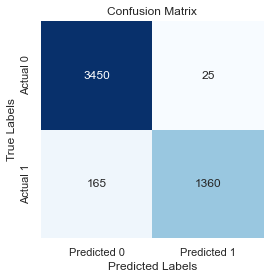

In [160]:
sns.set(font_scale=1)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [152]:
accuracy = accuracy_score(y_true_np, y_pred_np)
precision = precision_score(y_true_np, y_pred_np)
recall = recall_score(y_true_np, y_pred_np)
f1 = f1_score(y_true_np, y_pred_np)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1)

classification_rep = classification_report(y_true_np, y_pred_np)

Accuracy: 0.962
Precision: 0.9819494584837545
Recall (Sensitivity): 0.8918032786885246
F1 Score: 0.9347079037800687


In [161]:
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      3475
         1.0       0.98      0.89      0.93      1525

    accuracy                           0.96      5000
   macro avg       0.97      0.94      0.95      5000
weighted avg       0.96      0.96      0.96      5000



- Detection

In [187]:
with torch.no_grad(): 
    for batch in test_dl:
        inputs,target = batch
        outputs = model(inputs)
        sample_num = 0
        for i in outputs.max(axis=1)[1]:
            polarity = "yes" if i==1 else "no"
            print(f"sample:{sample_num} | malware detected:{polarity}")
            sample_num+=1
            if sample_num==20:
                break

sample:0 | malware detected:yes
sample:1 | malware detected:no
sample:2 | malware detected:no
sample:3 | malware detected:no
sample:4 | malware detected:no
sample:5 | malware detected:no
sample:6 | malware detected:no
sample:7 | malware detected:no
sample:8 | malware detected:no
sample:9 | malware detected:no
sample:10 | malware detected:no
sample:11 | malware detected:no
sample:12 | malware detected:no
sample:13 | malware detected:yes
sample:14 | malware detected:yes
sample:15 | malware detected:yes
sample:16 | malware detected:yes
sample:17 | malware detected:no
sample:18 | malware detected:no
sample:19 | malware detected:no
